## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read in dataset & view top rows
df_ab = pd.read_csv('ab_data.csv')
df_ab.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df_ab.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
len(df_ab.user_id.unique())

290584

d. The proportion of users converted.

In [5]:
converted = df_ab.converted.value_counts()
print(f"Proportion of converted: {converted[1] / (converted[0] + converted[1])}")

Proportion of converted: 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
first = df_ab.query('group=="treatment" & landing_page!="new_page"')
second = df_ab.query('landing_page=="new_page" & group!="treatment"')
len(first) + len(second)

3893

f. Do any of the rows have missing values?

In [7]:
pd.isna(first).count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [8]:
pd.isna(second).count()

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

`2.`
a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = first.copy()
df2.append(second)
df2.head(5)

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [10]:
df2 = df2.append(second)

In [11]:
len(df2)

3893

### Misunderstood and put all of the bad rows into DF2. I will see about removing all of the DF2 rows from df_ab

In [12]:
# make copy so as to keep df2 intact
df_mess = df2.copy()

In [13]:
df_mess.head(5)

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


### Remove the rows that match df_mess

In [14]:
df2 = pd.concat([df_ab, df_mess, df_mess]).drop_duplicates(keep=False)
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [15]:
len(df2)

290585

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` a. How many unique **user_id**s are in **df2**?

In [17]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.

In [18]:
df2_dup = df2[df2.user_id.duplicated()]
df2_dup

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [19]:
#see above

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [21]:
df2.drop(1899, inplace=True)
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
# get all rows that have a successful conversion
df2_conv = df2[df2.converted == 1]

In [23]:
# how many records
all_convert = len(df2_conv)
all_convert

34753

In [24]:
# how many total transactions
all_peeps = len(df2)
all_peeps

290584

In [25]:
# Probability of conversion regardless of page they receive
all_convert / all_peeps

0.11959708724499628

In [26]:
# get all control rows
df2_all_control = df2[df2.group == 'control']
all_control = len(df2_all_control)
all_control

145274

In [27]:
# get all control rows that converted
df2_control_conv = df2_all_control[df2_all_control.converted == 1]
len(df2_control_conv)

17489

b. Given that an individual was in the `control` group, what is the probability they converted?

In [28]:
# get percentage of control transactions that converted
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [29]:
# get percentage of treatment transactions that converted
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [30]:
len(df2[df2.landing_page == 'new_page']) / all_peeps

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

__Considering the results from parts (a) through (d) above, there is NOT sufficient evidents to conclude that the new treatment page leads to more conversions.__The control converted percentage is 0.12 and the treatment converted percentage is slightly LESS at 0.118. They essentially have the same conversion.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

*Null:* uP_new - uP_old <= 0

*ALT:* uP_new - uP_old > 0

---

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [31]:
# We are looking at a null where there is no difference in conversion based
# on page, which means the conversions for each page are the same.

p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [32]:
# We are looking at a null where there is no difference in conversion based
# on page, which means the conversions for each page are the same.

p_old = df2.converted.mean()
p_old

0.11959708724499628

In [33]:
# show that there is no difference in conversion based on page
p_new - p_old

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [34]:
n_new = len(df2[df2.group == 'treatment'])
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [35]:
n_old = len(df2[df2.group == 'control'])
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [36]:
new_page_converted = []
new_page_converted = np.random.choice([0,1],n_new,[1-p_new,p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [37]:
old_page_converted = []
old_page_converted = np.random.choice([0,1],n_old,[1-p_old,p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [38]:
#new_page_converted.mean() - old_page_converted.mean()
obs_diff = np.mean(new_page_converted) - np.mean(old_page_converted)
obs_diff

-0.0013557785262576783

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#mpl.style.use('ggplot')
%matplotlib inline

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [40]:
p_diffs = np.array(0)
new_page_converted = []
old_page_converted = []

for _ in range(10000):
    bootsamp2 = df2.sample(n_new, replace=True)
    new_page_converted = np.random.choice([0,1],n_new,[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1],n_old,[1-p_old,p_old])
    diff = np.mean(new_page_converted) - np.mean(old_page_converted)
    p_diffs = np.append(p_diffs, diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

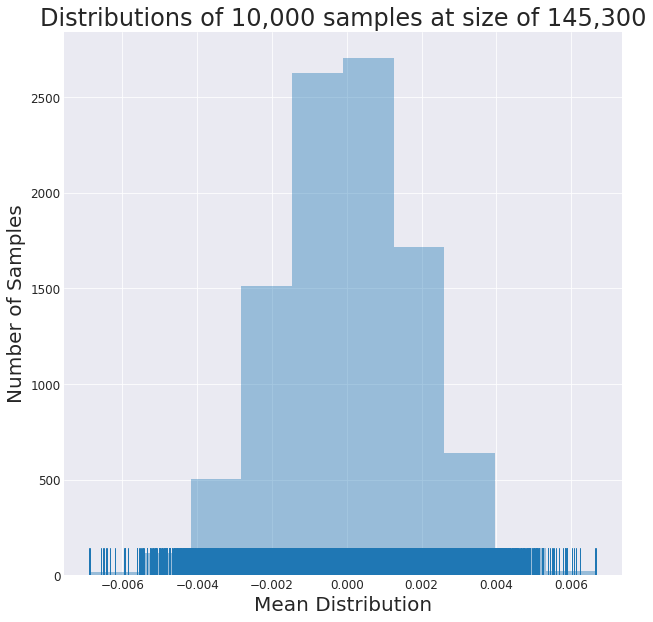

In [41]:
plt.figure(figsize=(10,10))
sns.distplot(p_diffs, bins=10, kde=False, rug=True);

plt.xlabel('Mean Distribution', fontsize=20)
plt.title('Distributions of 10,000 samples at size of 145,300', fontsize=24)
plt.ylabel('Number of Samples', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [42]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

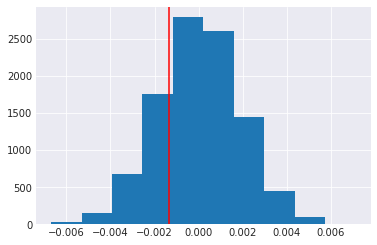

In [43]:
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

## p-value

In [44]:
# Calculate the p-value 
# These are all the null values that are more extreme than our statistic in favor of our alternative

(null_vals > obs_diff).mean()

0.76852314768523144

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [45]:
actual_new_conv = df2[df2.landing_page == 'new_page']['converted'].mean()
actual_old_conv = df2[df2.landing_page == 'old_page']['converted'].mean()

actual_diff = actual_new_conv - actual_old_conv

print(f"Actual difference in new & old conversion means: {actual_diff}")

Actual difference in new & old conversion means: -0.0015782389853555567


In [46]:
diff_prop = np.greater(p_diffs,actual_diff)

In [47]:
# Proportion of p_diffs that are greater than the actual difference observed in ab_data
diff_prop.mean()

0.80611938806119388

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Utilizing the ab_data, we set out to determine whether the null hypothesis, **uP_new - uP_old <= 0**, the mean conversion rate of the new webpage minus the mean conversation rate of the old webpage is less than or equal to 0. In other words, that the old and new webpages produce the same (or near same) conversation rates.

The p-value calculated under heading p-value, indicates that **94%** of all the null values are more extreme than our statistic in favor of the alternative.

Therefore, we **failed to reject the null hypothesis** which essentially means there is not enough evidence to say that it is false.

---

l. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

### z-test attempt as well as setup for stats.proportions_ztest

In [48]:
import statsmodels.api as sm

old_data = df2[df2.landing_page == 'old_page']['converted']
mu_convert_old = df2[df2.landing_page == 'old_page']['converted'].mean()
std_convert_old = df2[df2.landing_page == 'old_page']['converted'].std()

new_data = df2[df2.landing_page == 'new_page']['converted']
mu_convert_new = df2[df2.landing_page == 'new_page']['converted'].mean()
std_convert_new = df2[df2.landing_page == 'new_page']['converted'].std()

n_old = len(df2[df2.group == 'control'])
n_new = len(df2[df2.group == 'treatment'])

print(n_old,mu_convert_old,std_convert_old)
print(n_new,mu_convert_new,std_convert_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


145274 0.1203863045 0.32541384592
145310 0.118808065515 0.323563640675


In [49]:
sm.stats.ztest(old_data,new_data,alternative='two-sided')

(1.3109235634981506, 0.18988358901317048)

In [50]:
mu_convert_old

0.1203863045004612

In [51]:
mu_convert_new

0.11880806551510564

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [52]:
sm.stats.proportions_ztest(mu_convert_new * n_new, n_new, mu_convert_old, alternative='larger')

(-1.859354929150913, 0.96851157707008961)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score reveals that it is **-1.9 standard deviations** away from the mean. The p-value is even higher than our manual hypothesis testing and suggests that under the null hypothesis, the difference in the new & old conversion rates are **0, and is 97%** in favor of our null  **

---

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

---

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [53]:
# create numerical dummy columns for the group categorical column
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0


In [54]:
# create numerical dummy columns for the landing_page categorical column
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,1,0


In [55]:
# rename the treatment column to ab_page
df2 = df2.rename(columns={'treatment':'ab_page'})
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,1


In [56]:
# remove control column. It's values are represented by a 0 in the ab_page column
df2.drop(columns=['control'],inplace=True)

In [57]:
# remove old_page column. It's values are represented by a 0 in the new_page column
df2.drop(columns=['old_page'], inplace=True)
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [58]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [59]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 16:34 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

#### Using Logistic Regression model, the NULL & ALT hypothesis are:  
H0: uP_new = uP_old  
H1: uP_new != uP_old  
  
#### In Part II, the NULL & ALT hypothesis are:  
H0: uP_new - uP_old <= 0  
H1: uP_new - uP_old > 0  

The p-value associated with the **ab_page** is **0.19**. It differs from the null & alt hypothesis in Part II because, as hinted, the hypothesis for the Logistic Reg. model in says that the new page conversion will equal the old page conversion, which is a much more definitive statement, and leaves no room for small differences between the 2 conversions. Whereas, the Part II hypothesis give a much larger area for the NULL to be True. The number of values that satisfy the **uP_new - uP_old <= 0** is much great than **uP_new = uP_old**.

---

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is a good idea to see what other factors can influence your models and the relationships between the variables. However, there are numerous problems that one may contend with when adding additional variables. **Linearity, Correlated Errors, Non-constant Variance and Normally Distributed Errors, Outliers/Leverage points, & Multi-collinearity** are some issues that may or may not arise with more complex models.

---

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [60]:
# read in countries.csv
country_df = pd.read_csv("countries.csv")
country_df.head(5)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [61]:
# merge countries dataframe with df3 dataframe. Using new df3 dataframe to preserve the df2 dataframe
df3 = pd.merge(df2, country_df, on='user_id')
df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,0,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,0,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,CA


In [62]:
# see how the new_page & old_page counts are represented by country
df3.groupby(df3['country'])['landing_page'].value_counts()

country  landing_page
CA       new_page          7301
         old_page          7198
UK       old_page         36360
         new_page         36106
US       new_page        101903
         old_page        101716
Name: landing_page, dtype: int64

In [63]:
# create numerical dummy columns for categorical country column
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0,1


In [64]:
# verify if dummy creation accurate
df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,CA,1,0,0


In [65]:
# create logistic model utilizing the US as the intercept
log_mod2 = sm.Logit(df3['converted'], df3[['intercept','CA','UK']])
results = log_mod2.fit()

# display the results
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 16:34 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

Unfortunately, adding the country data to the model does not increase the likiness of a page conversion, with **p-values: 0.13, & 0.46**. 

---

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [66]:
# create logistic model utilizing Canada (CA) as the intercept
log_mod3 = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','UK']])
results = log_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [67]:
# display the results
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 16:34 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

After adding the ab_page variable, the results remain similar. The data, including old or new page, country of origin, CA, UK, & US, does not give us sufficient evidents, at least evidence that falls below alpha of 0.05, that the conversion rate of the new page is better than the conversion rate of the old page. 

---

## Influences associated with time on conversion

In [68]:
# add additional time data to a new dataframe to keep df3 at current state
df4 = df3.copy()

In [69]:
df4.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,US,0,0,1


In [70]:
# check datatypes, notice the timestamp column is an object, not a datetime type
df4.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
ab_page          uint8
new_page         uint8
country         object
CA               uint8
UK               uint8
US               uint8
dtype: object

In [71]:
# convert datatype for timestamp column to datetime
df4['timestamp'] = pd.to_datetime(df4['timestamp'])

In [72]:
df4.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
intercept                int64
ab_page                  uint8
new_page                 uint8
country                 object
CA                       uint8
UK                       uint8
US                       uint8
dtype: object

In [73]:
earliest = df4.timestamp.min()
latest = df4.timestamp.max()
print(earliest.ctime())
print(latest.dayofweek)

Mon Jan  2 13:42:05 2017
1


In [74]:
split_earl = earliest.ctime().split()
split_earl

['Mon', 'Jan', '2', '13:42:05', '2017']

In [75]:
print(earliest.dayofweek)

0


In [76]:
df4.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0,1


In [77]:
# function to extract day of week from timestamp and categorize new column with 
# appropriate designation, weekend or weekday

def add_day(row):
    timestamp_day = row.timestamp
    return(timestamp_day.ctime().split()[0])   

In [78]:
# function to extract day of week from timestamp and categorize new column with 
# appropriate designation, weekend or weekday

def weekend(row):
    timestamp_day = row.timestamp.dayofweek
       
    if timestamp_day == 6 or timestamp_day == 0:
        return 1
    else:
        return 0

In [79]:
# function to extract day of week from timestamp and categorize new column with 
# appropriate designation, weekend or weekday

def weekday(row):
    timestamp_day = row.timestamp.dayofweek
    #if timestamp_day == 6 or timestamp_day == 0:   
    if timestamp_day > 0 and timestamp_day < 6:
        return 1
    else:
        return 0

In [80]:
## function to extract time of day from timestamp and categorize new column with
## appropriate designation, daytime or nighttime

def daytime(row):
    view_time = row.timestamp.ctime().split()[3]
    
    if view_time > '06:30:00' and view_time < '19:00:00':
        return 1
    else:
        return 0

In [81]:
# run weekend function on every row to categorize the timestamp as occurring
# on the weekend 

df4['weekend'] = df4.apply(lambda row: weekend(row), axis=1)

In [82]:
# run weekday function on every row to categorize the timestamp as occurring
# on the weekday 

df4['weekday'] = df4.apply(lambda row: weekday(row), axis=1)

In [83]:
# run daytime function on every row to categorize the timestamp as occurring
# during the day or night

df4['daytime'] = df4.apply(lambda row: daytime(row), axis=1)

In [86]:
df4.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country,CA,UK,US,weekend,weekday,daytime
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,US,0,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,US,0,0,1,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,US,0,0,1,0,1,0


In [88]:
log_mod4 = sm.Logit(df4['converted'], df4[['intercept','ab_page','weekday']])
results = log_mod4.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [90]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 16:54 AIC:              212782.2460
No. Observations:   290584           BIC:              212813.9850
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9859    0.0120  -165.9746  0.0000  -2.0094  -1.9625
ab_page      -0.0150    0.0114    -1.3103  0.1901  -0.0374   0.0074
weekday      -0.0040    0.0125    -0.3229  0.7468  -0.0286   0.0205
==================================================================

"""

In [91]:
log_mod5 = sm.Logit(df4['converted'], df4[['intercept','ab_page','daytime']])
results = log_mod5.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [92]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-14 16:55 AIC:              212776.9638
No. Observations:   290584           BIC:              212808.7028
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0027    0.0101  -199.0636  0.0000  -2.0224  -1.9830
ab_page      -0.0150    0.0114    -1.3160  0.1882  -0.0375   0.0074
daytime       0.0266    0.0115     2.3205  0.0203   0.0041   0.0490
==================================================================

"""

Utilizing these methods:

1. Probability
2. A/B Test
3. zTest
4. Logistic Regression

it was unaminously calculated that the new_page design **DID NOT** provide enough statistical & practical evidence to confirm the likelness that conversions would increase consistently under the Type II error rate of 0.05.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [85]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])